## So sánh các phương pháp Over-sampling

Chúng ta sẽ xác định xem liệu các thuật toán oversampling mà chúng ta đã học có cải thiện chất lượng của Random Forest trên các tập dữ liệu khác nhau với các lớp mất cân bằng không.

In [1]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from imblearn.datasets import fetch_datasets

from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks


from imblearn.over_sampling import (
    SMOTE,
    BorderlineSMOTE,
    SVMSMOTE,
)

from imblearn.combine import SMOTEENN, SMOTETomek

In [2]:
oversampler_dict = {

    'smote': SMOTE(
        sampling_strategy='auto',
        random_state=0,
        k_neighbors=5,
        n_jobs=4),

    'border1': BorderlineSMOTE(
        sampling_strategy='auto',
        random_state=0,
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-1',
        n_jobs=4),

    'svm': SVMSMOTE(
        sampling_strategy='auto',
        random_state=0,
        k_neighbors=5,
        m_neighbors=10,
        n_jobs=4,
        svm_estimator=SVC(kernel='linear')),

    'smenn': SMOTEENN(
        sampling_strategy='auto',
        random_state=0,
        smote=SMOTE(sampling_strategy='auto', random_state=0, k_neighbors=5),
        enn=EditedNearestNeighbours(
            sampling_strategy='auto', n_neighbors=3, kind_sel='all'),
        n_jobs=4),

    'smtomek': SMOTETomek(
        sampling_strategy='auto',
        random_state=0,
        smote=SMOTE(sampling_strategy='auto', random_state=0, k_neighbors=5),
        tomek=TomekLinks(sampling_strategy='all'),
        n_jobs=4),

}

In [3]:
datasets_ls = [
    'car_eval_34',
    'ecoli',
    'thyroid_sick',
    'arrhythmia',
    'ozone_level'
]

In [4]:
# in ra mất cân bằng lớp
## Yêu cầu 1:
## VIẾT CODE Ở ĐÂY:
for dataset in datasets_ls:
    data = fetch_datasets()[dataset]
    print(dataset)
    print(Counter(data.target))
    print()

car_eval_34
Counter({-1: 1594, 1: 134})

ecoli
Counter({-1: 301, 1: 35})

thyroid_sick
Counter({-1: 3541, 1: 231})

arrhythmia
Counter({-1: 427, 1: 25})

ozone_level
Counter({-1: 2463, 1: 73})



<details><summary> Gợi ý </summary>

Sử dụng ```dataset```

</details>

In [5]:
# hàm huấn luyện random forest và đánh giá chất lượng

def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(
        n_estimators=100, random_state=39, max_depth=2, n_jobs=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

    return roc_auc_score(y_test, pred[:, 1])

In [6]:
# lưu kết quả
results_dict = {}
shapes_dict = {}

## Yêu cầu 2:
## VIẾT CODE Ở ĐÂY:

for dataset in datasets_ls:
    
    results_dict[dataset] = {}
    shapes_dict[dataset] = {}
    
    print(dataset)
    
    # load tập dữ liệu
    data = fetch_datasets()[dataset]
    
    # tách thành tập huấn luyện và tập kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(
    data.data,  
    data.target, 
    test_size=0.3,
    random_state=0)
    
    # do một số kỹ thuật oversampling sử dụng KNN
    # chúng ta thiết lập các biến ở cùng một tỷ lệ
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
        
    roc = run_randomForests(X_train, X_test, y_train, y_test)
    
    # lưu trữ kết quả
    results_dict[dataset]['full_data'] = roc
    shapes_dict[dataset]['full_data'] = len(X_train)
    
    print()
    
    for oversampler in oversampler_dict.keys():
        
        print(oversampler)
        
        # lấy lại mẫu
        X_resampled, y_resampled = oversampler_dict[oversampler].fit_resample(X_train, y_train)
        
        # đánh giá chất lượng
        roc = run_randomForests(X_resampled, X_test, y_resampled, y_test)
        
        # lưu trữ kết quả
        results_dict[dataset]["full_data"] = roc
        shapes_dict[dataset]["full_data"] = len(X_resampled)
        print()
        
    print()
        

car_eval_34
Train set
Random Forests roc-auc: 0.9581261802905924
Test set
Random Forests roc-auc: 0.9440504133074803

smote
Train set
Random Forests roc-auc: 0.9892067644300562
Test set
Random Forests roc-auc: 0.982268598836616

border1


C:\Users\NCPC\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\NCPC\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\over_sampling\_smote\filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Train set
Random Forests roc-auc: 0.9892200125897663
Test set
Random Forests roc-auc: 0.9863506480253086

svm
Train set
Random Forests roc-auc: 0.9898226031268869
Test set
Random Forests roc-auc: 0.9834677007857945

smenn


C:\Users\NCPC\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\over_sampling\_smote\filter.py:461: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Train set
Random Forests roc-auc: 0.9891561805475264
Test set
Random Forests roc-auc: 0.9806868047759976

smtomek
Train set
Random Forests roc-auc: 0.9892067644300562
Test set
Random Forests roc-auc: 0.982268598836616


ecoli
Train set
Random Forests roc-auc: 0.9716599190283401
Test set
Random Forests roc-auc: 0.9408212560386474

smote
Train set
Random Forests roc-auc: 0.9773356837068748
Test set
Random Forests roc-auc: 0.9601449275362319

border1
Train set
Random Forests roc-auc: 0.9769121586044276
Test set
Random Forests roc-auc: 0.9806763285024154

svm


C:\Users\NCPC\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\NCPC\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\over_sampling\_smote\filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\NCPC\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\over_sampling\_smote\filter.py:461: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Train set
Random Forests roc-auc: 0.9779080149263981
Test set
Random Forests roc-auc: 0.9613526570048309

smenn
Train set
Random Forests roc-auc: 0.9799868846088456
Test set
Random Forests roc-auc: 0.9601449275362319

smtomek
Train set
Random Forests roc-auc: 0.9805843195266272
Test set
Random Forests roc-auc: 0.961352657004831


thyroid_sick
Train set
Random Forests roc-auc: 0.9646448684059303
Test set
Random Forests roc-auc: 0.9521203914568843

smote
Train set
Random Forests roc-auc: 0.9605968807461769
Test set
Random Forests roc-auc: 0.9487843909644857

border1


C:\Users\NCPC\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\NCPC\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\over_sampling\_smote\filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Train set
Random Forests roc-auc: 0.9617160200097215
Test set
Random Forests roc-auc: 0.9432572167169323

svm
Train set
Random Forests roc-auc: 0.9694301766481193
Test set
Random Forests roc-auc: 0.9401797254877824

smenn


C:\Users\NCPC\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\over_sampling\_smote\filter.py:461: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Train set
Random Forests roc-auc: 0.9608931138808913
Test set
Random Forests roc-auc: 0.9477072690342832

smtomek
Train set
Random Forests roc-auc: 0.9596432542432676
Test set
Random Forests roc-auc: 0.947190250507786


arrhythmia
Train set
Random Forests roc-auc: 0.9931143025772182
Test set
Random Forests roc-auc: 0.8515625

smote
Train set
Random Forests roc-auc: 0.9987919598214785
Test set
Random Forests roc-auc: 0.908203125

border1
Train set
Random Forests roc-auc: 0.9985123208912652
Test set
Random Forests roc-auc: 0.796875


C:\Users\NCPC\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\NCPC\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\over_sampling\_smote\filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(



svm
Train set
Random Forests roc-auc: 0.9983006417789027
Test set
Random Forests roc-auc: 0.8955078125

smenn
Train set
Random Forests roc-auc: 0.9994407221395734
Test set
Random Forests roc-auc: 0.9384765625

smtomek


C:\Users\NCPC\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\over_sampling\_smote\filter.py:461: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Train set
Random Forests roc-auc: 0.9987919598214785
Test set
Random Forests roc-auc: 0.908203125


ozone_level
Train set
Random Forests roc-auc: 0.9333229162016161
Test set
Random Forests roc-auc: 0.8202702702702702

smote
Train set
Random Forests roc-auc: 0.9554774113770573
Test set
Random Forests roc-auc: 0.8274774774774776

border1


C:\Users\NCPC\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\NCPC\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\over_sampling\_smote\filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Train set
Random Forests roc-auc: 0.9830520064310351
Test set
Random Forests roc-auc: 0.8708494208494209

svm
Train set
Random Forests roc-auc: 0.9823188644029144
Test set
Random Forests roc-auc: 0.8615186615186615

smenn


C:\Users\NCPC\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\over_sampling\_smote\filter.py:461: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Train set
Random Forests roc-auc: 0.9560529101847962
Test set
Random Forests roc-auc: 0.8290862290862291

smtomek
Train set
Random Forests roc-auc: 0.9554774113770573
Test set
Random Forests roc-auc: 0.8274774774774776




<details><summary> Gợi ý </summary>

Sử dụng ```dataset``` và ```oversampler```

</details>

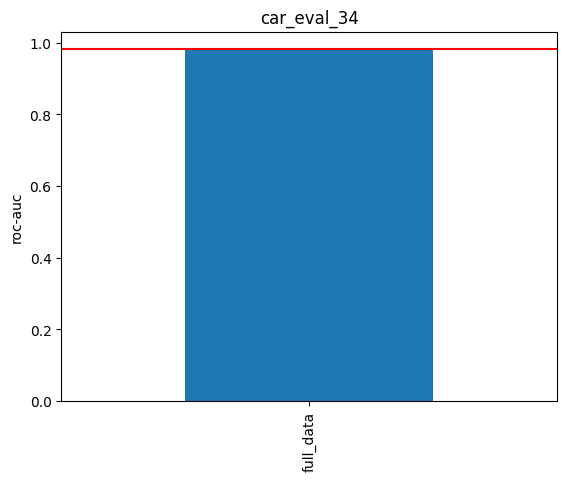

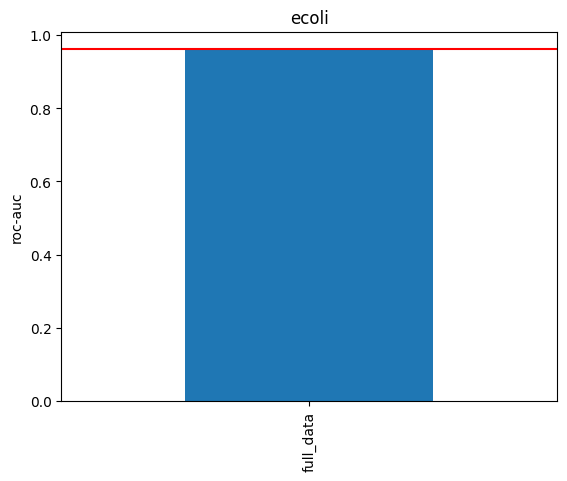

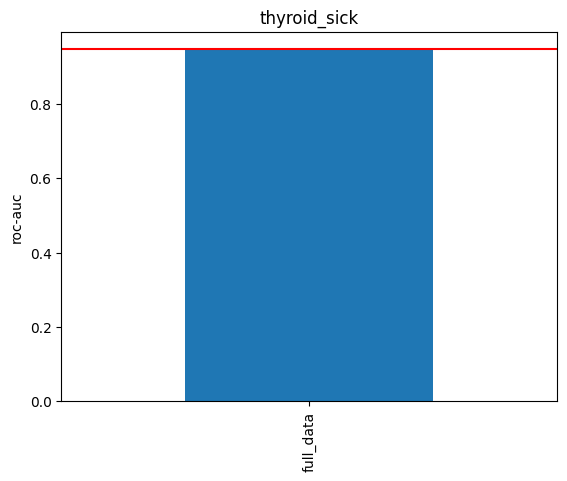

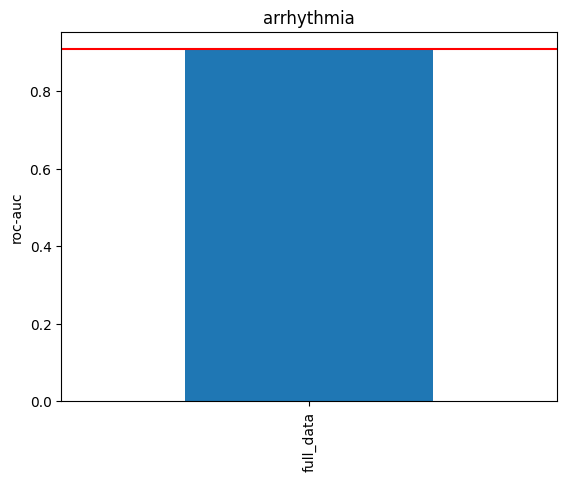

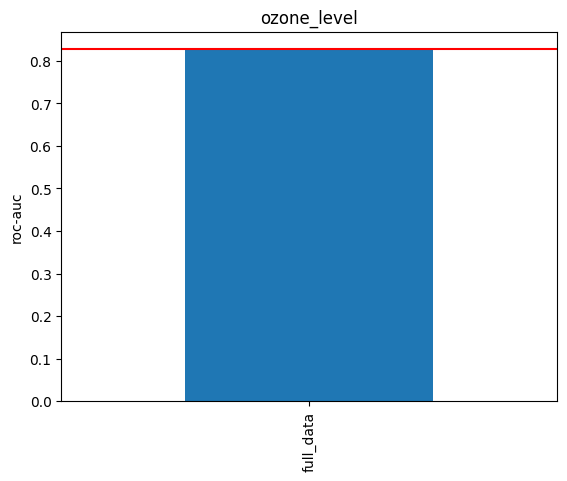

In [7]:
for dataset in datasets_ls:
    ## Yêu cầu 3:
    ## VIẾT CODE Ở ĐÂY:
    pd.Series(results_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('roc-auc')
#     plt.ylim(0.55, 0.9)
    plt.axhline(results_dict[dataset]['full_data'], color='r')
    plt.show()

<details><summary> Gợi ý </summary>

Sử dụng ```bar()``` để vẽ biểu đồ rồi sử dụng ```axhline()```

</details>

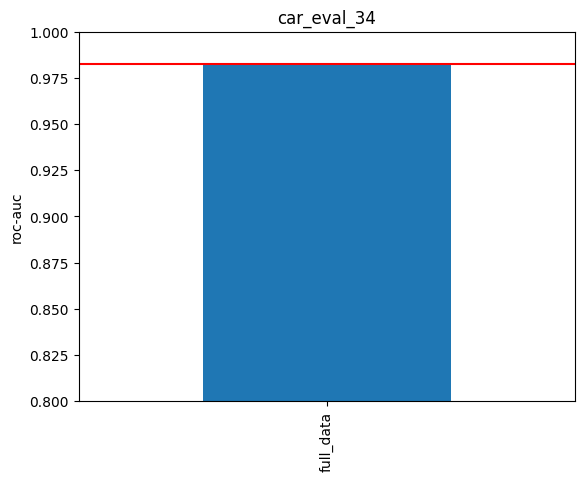

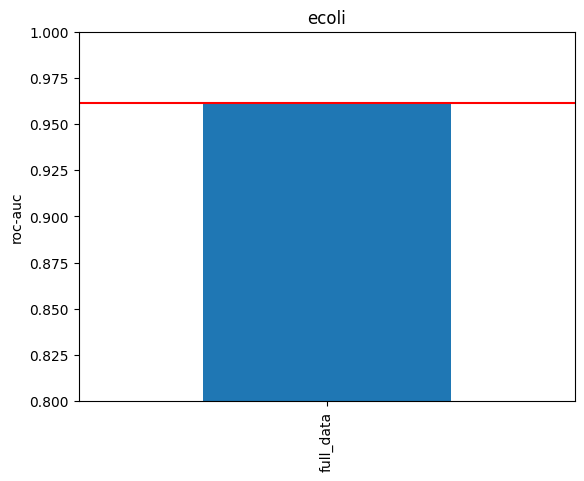

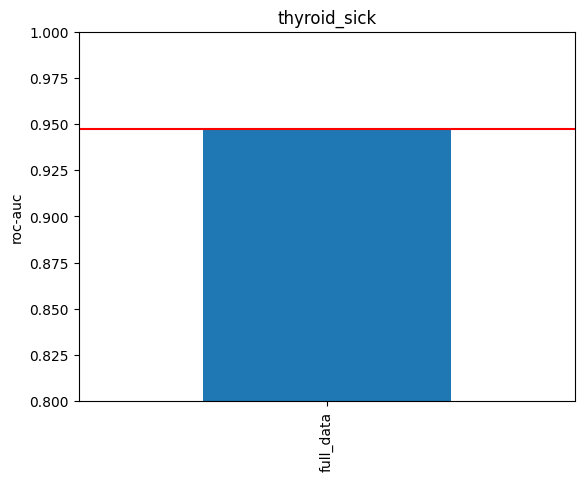

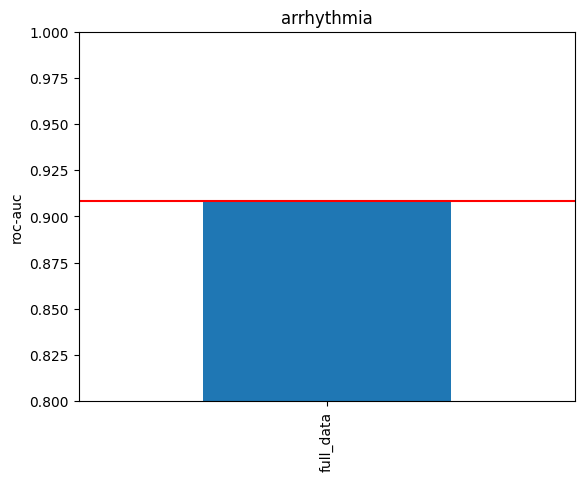

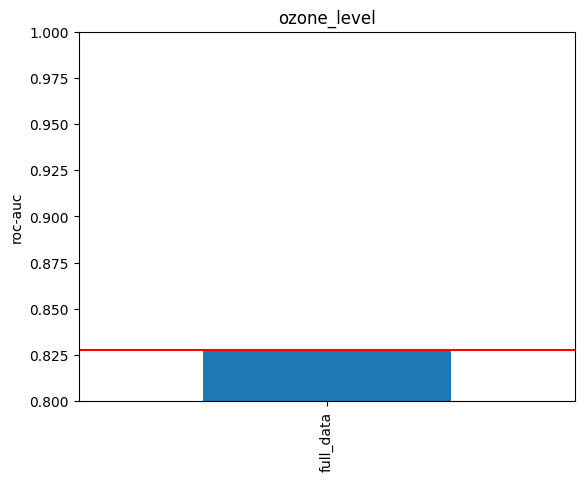

In [8]:
for dataset in datasets_ls:
    ## Yêu cầu 4:
    ## VIẾT CODE Ở ĐÂY:
    pd.Series(results_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('roc-auc')
    plt.ylim(0.8, 1)
    plt.axhline(results_dict[dataset]['full_data'], color='r')
    plt.show()

<details><summary> Gợi ý </summary>

Sử dụng ```bar()``` để vẽ biểu đồ rồi sử dụng ```axhline()```

</details>

Trong tập dữ liệu arrhythmia, kết hợp undersampling và oversampling có vẻ hoạt động tốt hơn so với SMOTE và bất kỳ kỹ thuật nào khác. Tuy nhiên, điều này thay đối tùy theo tập dữ liệu mà chúng ta thao tác.

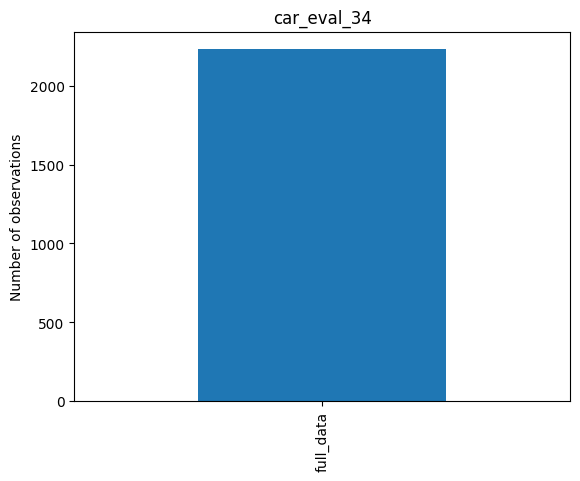

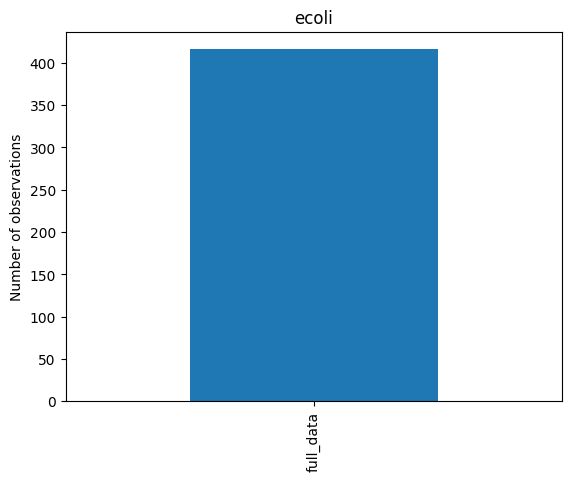

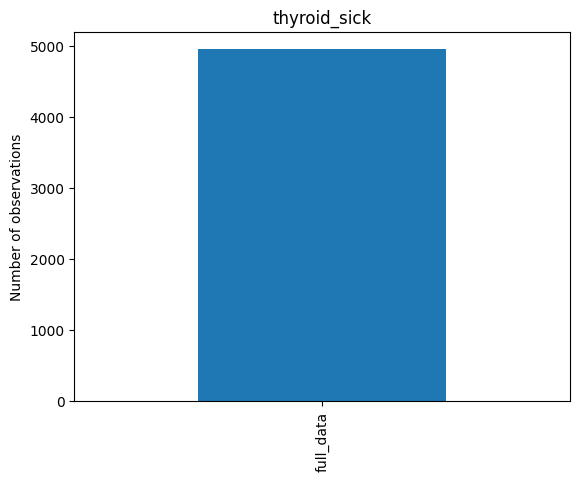

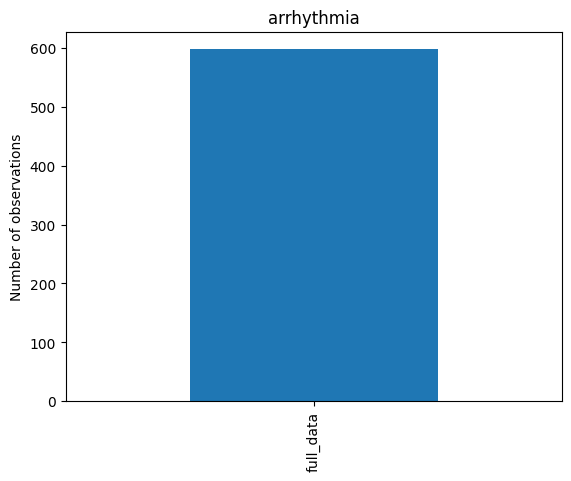

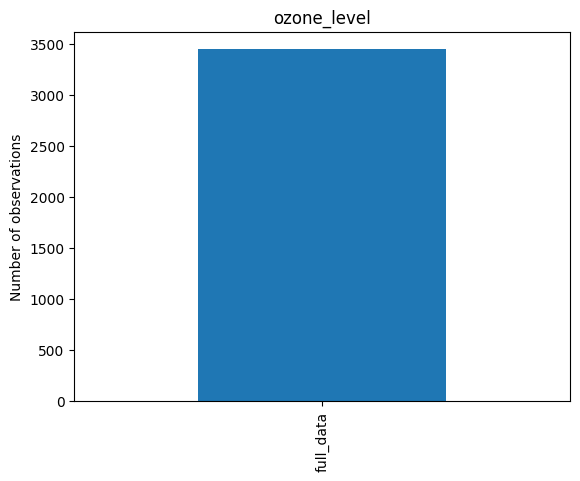

In [9]:
for dataset in datasets_ls:
    
    pd.Series(shapes_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('Number of observations')
    plt.show()